In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the dataset
dataset = pd.read_excel('DataReal.xlsx')

# Define the features and the target
X = dataset.iloc[:, :6].values
y = dataset.iloc[:, -2].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename)

# Build and train the ANN with modifications
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=13, activation='relu'),  # One hidden layer with 13 neurons
    tf.keras.layers.Dense(units=1)  # Output layer remains unchanged
])
ann.compile(optimizer='adam', loss='mean_squared_error')
ann.fit(X_train_scaled, y_train, batch_size=32, epochs=100)

# Save the model
ann.save("saved_model.h5")


Epoch 1/100
1/1 [==============================] - 0s 357ms/step - loss: 1.0977
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 1.0795
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 1.0616
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0441
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0267
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0096
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.9928
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.9762
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9598
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9439
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9281
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9126
Epoch 13/100
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 34ms/step
scaled: [[0.09259259 0.45614035 0.         1.         1.         0.        ]]
Predictions: [[0.04297978]]
1/1 [==============================] - 0s 18ms/step


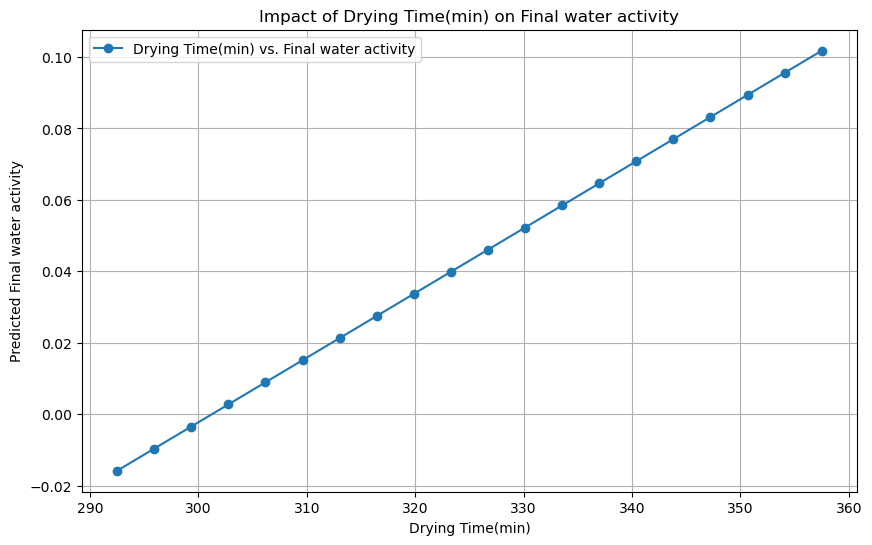

1/1 [==============================] - 0s 13ms/step


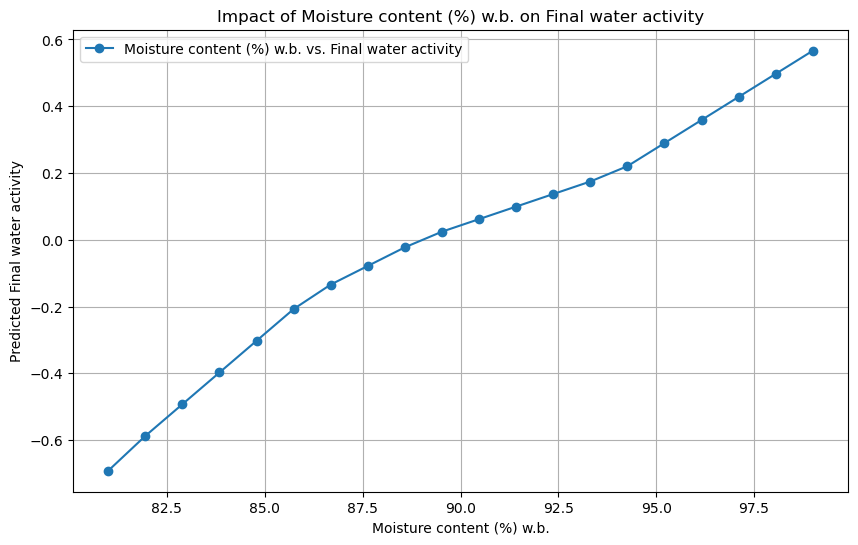

1/1 [==============================] - 0s 13ms/step


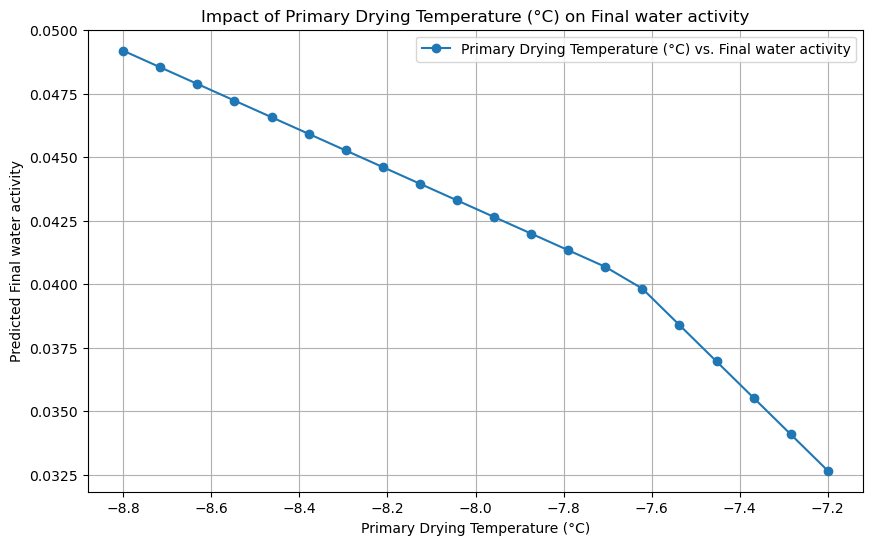

1/1 [==============================] - 0s 14ms/step


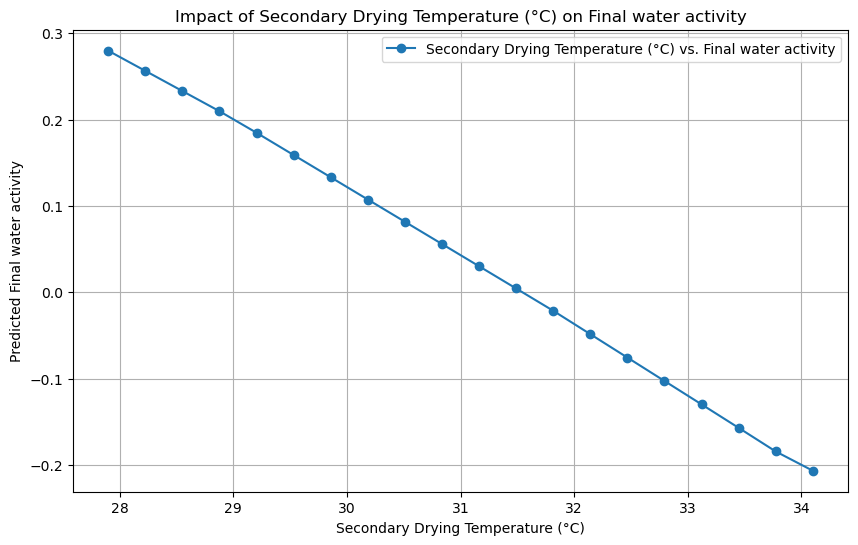

1/1 [==============================] - 0s 14ms/step


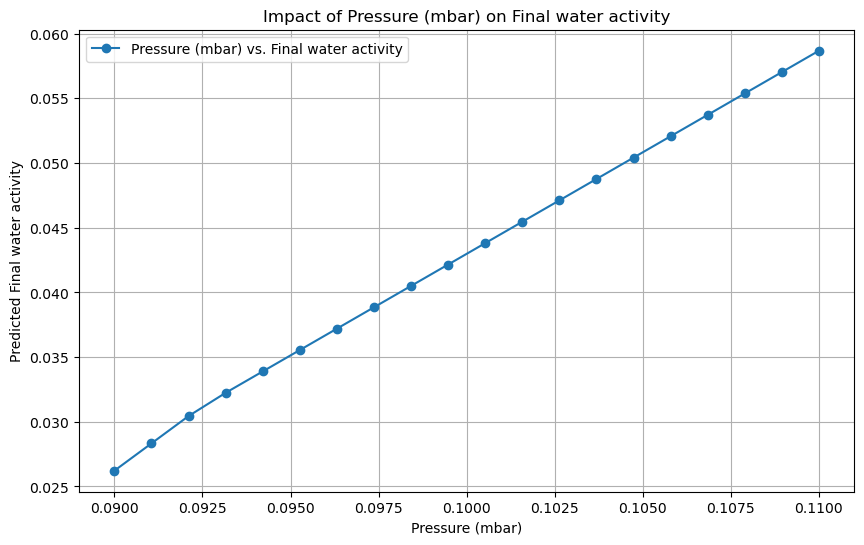

1/1 [==============================] - 0s 14ms/step


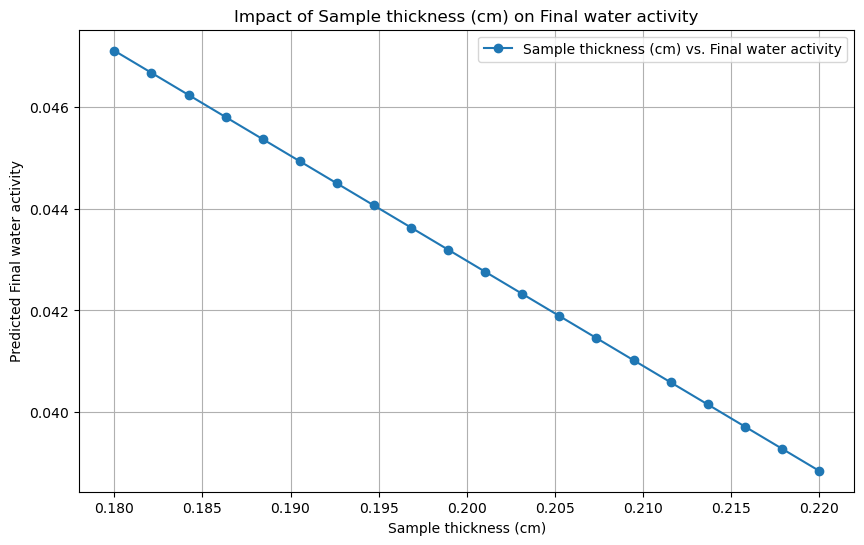

In [7]:
import tensorflow as tf
import numpy as np
model = tf.keras.models.load_model("saved_model.h5")
# Scale the new input data using the same scaler
new_input_variables = np.array([[325,90,-8,31,0.1,0.2]]) # Manually input data
new_input_variables_scaled = scaler.transform(new_input_variables)

# Make predictions with the loaded model
predictions = model.predict(new_input_variables_scaled)

# Post-process predictions if needed (e.g., ensure non-negative outputs)
print("scaled:", new_input_variables_scaled)
# Print the predictions
print("Predictions:", predictions)

import matplotlib.pyplot as plt

# Assuming X_train is your original training data before scaling
feature_names = ["Drying Time(min)", "Moisture content (%) w.b.", "Primary Drying Temperature (°C)", "Secondary Drying Temperature (°C)", "Pressure (mbar)", "Sample thickness (cm)"]

# Vary each feature slightly (e.g., ±10% of its original value)
variation_percentage = 0.1

for i in range(new_input_variables.shape[1]):
    original_value = new_input_variables[0, i]
    varied_values = np.linspace(original_value * (1 - variation_percentage), original_value * (1 + variation_percentage), 20)
    
    # Create a new array for each varied value, keeping other values constant
    varied_inputs = np.tile(new_input_variables, (len(varied_values), 1))
    varied_inputs[:, i] = varied_values
    
    # Scale the varied inputs
    varied_inputs_scaled = scaler.transform(varied_inputs)
    
    # Predict the final water activity for these varied inputs
    predictions = model.predict(varied_inputs_scaled).flatten()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(varied_values, predictions, '-o', label=f'{feature_names[i]} vs. Final water activity')
    plt.xlabel(feature_names[i])
    plt.ylabel('Predicted Final water activity')
    plt.title(f'Impact of {feature_names[i]} on Final water activity')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Load the dataset and initialize the scaler
dataset = pd.read_excel('DataReal.xlsx')
X_train = dataset.iloc[:, :6].values  # Assuming the first 6 columns are features

scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit the scaler to the training data

# Load the trained model
model = tf.keras.models.load_model('saved_model.h5')

# Fixed inputs
fixed_moisture_content = 76  # Example fixed value
fixed_sample_thickness = 0.8   # Example fixed value

# Target output
target_output = 0.6

# Define the search space
space = [Real(83, 1097, name='drying_time'),
         Real(-8, -2, name='primary_drying_temp'),
         Real(25, 31, name='secondary_drying_temp'),
         Real(0.04, 0.1, name='pressure')]

# Define the objective function to minimize
@use_named_args(space)
def objective_function(drying_time, primary_drying_temp, secondary_drying_temp, pressure):
    # Arrange the inputs in the specified order
    inputs = np.array([drying_time, fixed_moisture_content, primary_drying_temp, secondary_drying_temp, pressure, fixed_sample_thickness])
    
    # Scale the inputs
    scaled_inputs = scaler.transform(inputs.reshape(1, -1))
    
    # Make a prediction
    prediction = model.predict(scaled_inputs)[0][0]
    
    # Calculate the error
    error = abs(prediction - target_output)
    
    return error

# Perform Bayesian Optimization
result = gp_minimize(objective_function, space, n_calls=50, random_state=0)

# Extract the optimized parameters
optimized_params = result.x

# Arrange the optimized inputs in the correct order for final prediction
optimized_inputs = np.array([optimized_params[0], fixed_moisture_content, optimized_params[1], optimized_params[2], optimized_params[3], fixed_sample_thickness])
scaled_optimized_inputs = scaler.transform(optimized_inputs.reshape(1, -1))

# Make the final prediction
optimized_prediction = model.predict(scaled_optimized_inputs)[0][0]

# Display the results
print("Optimized input values:")
print(f"Drying Time (min): {optimized_params[0]}")
print(f"Moisture content (%) w.b.: {fixed_moisture_content}")
print(f"Primary Drying Temperature (°C): {optimized_params[1]}")
print(f"Secondary Drying Temperature (°C): {optimized_params[2]}")
print(f"Pressure (mbar): {optimized_params[3]}")
print(f"Sample thickness (cm): {fixed_sample_thickness}")
print(f"Predicted output (Final water activity): {optimized_prediction}")


OSError: SavedModel file does not exist at: saved_model\{saved_model.pbtxt|saved_model.pb}

1/1 [==============================] - 0s 21ms/step
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 104
         Function evaluations: 263
1/1 [==============================] - 0s 22ms/step
Optimized input values:
Drying Time (min): 416.68767171476725
Moisture content (%) w.b.: 90.0
Primary Drying Temperature (°C): -4.899833645965458
Secondary Drying Temperature (°C): 29.722776098210698
Pressure (mbar): 0.07749228734789285
Sample thickness (cm): 0.5
Predicted output (Final water activity): 0.6000000238418579


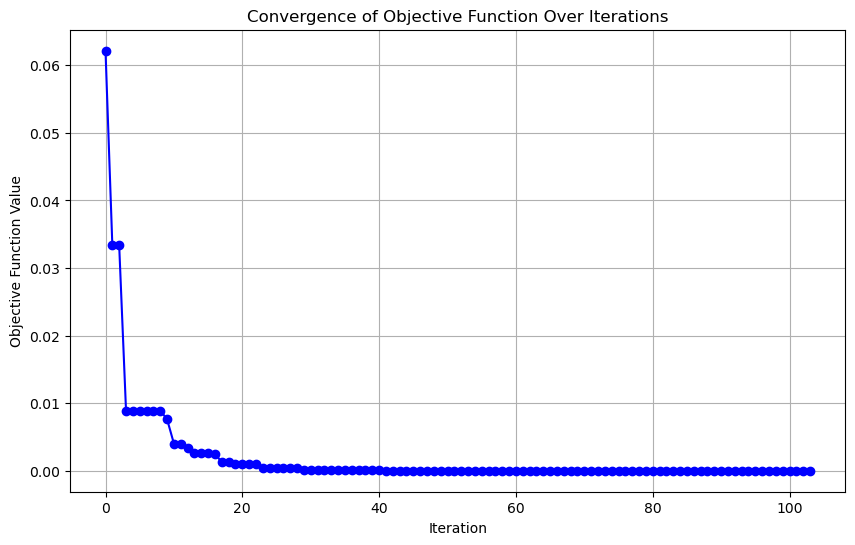

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the dataset and initialize the scaler
dataset = pd.read_excel('DataReal.xlsx')
X_train = dataset.iloc[:, :6].values  # Assuming the first 6 columns are features

scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit the scaler to the training data

# Load the trained model
model = tf.keras.models.load_model('saved_model.h5')

# Fixed inputs
fixed_moisture_content = 90.0  # Example fixed value
fixed_sample_thickness = 0.5   # Example fixed value

# Target output
target_output = 0.6

# Define the initial guess and bounds for the optimization
initial_guess = np.array([500.0, -5.0, 28.0, 0.07])
# bounds are defined but not used in Nelder-Mead, shown here for completeness
bounds = [(300, 600), (-8, -2), (25, 31), (0.04, 0.1)]

# Initialize a list to store objective function values at each iteration
objective_values = []

# Define the objective function to minimize
def objective_function(inputs):
    drying_time, primary_drying_temp, secondary_drying_temp, pressure = inputs
    arranged_inputs = np.array([drying_time, fixed_moisture_content, primary_drying_temp, secondary_drying_temp, pressure, fixed_sample_thickness])
    scaled_inputs = scaler.transform(arranged_inputs.reshape(1, -1))
    prediction = model.predict(scaled_inputs)[0][0]
    error = abs(prediction - target_output)
    return error

# Callback function to capture the objective function value at each iteration
def callback(xk):
    global objective_values
    fv = objective_function(xk)
    objective_values.append(fv)

# Perform optimization using Nelder-Mead method with callback
result = minimize(objective_function, initial_guess, method='Nelder-Mead', callback=callback, options={'xatol': 1e-8, 'disp': True})

# Extract the optimized parameters
optimized_params = result.x

# Arrange the optimized inputs in the correct order for final prediction
optimized_inputs = np.array([optimized_params[0], fixed_moisture_content, optimized_params[1], optimized_params[2], optimized_params[3], fixed_sample_thickness])
scaled_optimized_inputs = scaler.transform(optimized_inputs.reshape(1, -1))

# Make the final prediction
optimized_prediction = model.predict(scaled_optimized_inputs)[0][0]

# Display the results
print("Optimized input values:")
print(f"Drying Time (min): {optimized_params[0]}")
print(f"Moisture content (%) w.b.: {fixed_moisture_content}")
print(f"Primary Drying Temperature (°C): {optimized_params[1]}")
print(f"Secondary Drying Temperature (°C): {optimized_params[2]}")
print(f"Pressure (mbar): {optimized_params[3]}")
print(f"Sample thickness (cm): {fixed_sample_thickness}")
print(f"Predicted output (Final water activity): {optimized_prediction}")

# Plot the objective function values over iterations
plt.figure(figsize=(10, 6))
plt.plot(objective_values, marker='o', linestyle='-', color='blue')
plt.title('Convergence of Objective Function Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 21ms/step


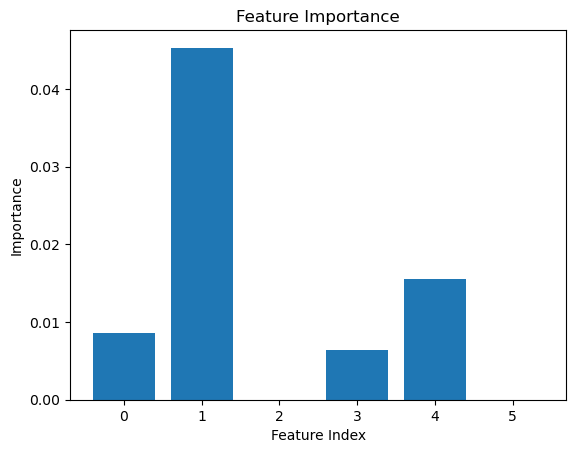

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the model
model = tf.keras.models.load_model('saved_model.h5')

dataset = pd.read_excel('DataReal.xlsx')

# Define the features and the target
X = dataset.iloc[:, :6].values
y = dataset.iloc[:, -2].values

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

def calculate_importance(model, X_val_scaled, y_val):
    # Store the original model's predictions
    original_predictions = model.predict(X_val_scaled).flatten()  # Ensure predictions are flattened to match y_val's shape
    original_error = mean_squared_error(y_val, original_predictions)
    feature_importance = []
    
    for i in range(X_val_scaled.shape[1]):
        # Shuffle one column at a time
        shuffled_X_val = X_val_scaled.copy()
        shuffled_X_val[:, i] = shuffle(shuffled_X_val[:, i])

        # Make predictions with the shuffled data and calculate error
        shuffled_predictions = model.predict(shuffled_X_val).flatten()  # Flatten predictions here as well
        shuffled_error = mean_squared_error(y_val, shuffled_predictions)

        # The importance is the increase in error
        importance = shuffled_error - original_error
        feature_importance.append(importance)
    
    return np.array(feature_importance)

# Calculate feature importance
importance = calculate_importance(model, X_val_scaled, y_val)

# Plot feature importance
plt.bar(range(X_val.shape[1]), importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [7]:
import tensorflow as tf
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
# Load the saved Keras model
loaded_model = tf.keras.models.load_model("saved_model.h5")

# Load the saved scaler
loaded_scaler = joblib.load("scaler.save")

# Assuming `new_dataset` is a pandas DataFrame similar to the original dataset
# For example, load new data
new_dataset = pd.read_excel('DataReal.xlsx')

X = dataset.iloc[:, :6].values
y = dataset.iloc[:, -2].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Predicting the test set results
y_pred = ann.predict(X_test_scaled)

# Use y_test as y_new_true here for demonstration
y_new_true = y_test  # This is assuming you're evaluating performance on the test set

# Calculate the metrics
mae = mean_absolute_error(y_new_true, y_pred)
mse = mean_squared_error(y_new_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_new_true, y_pred)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

1/1 [==============================] - 0s 38ms/step
MAE: 0.10720258537928262
MSE: 0.012104096963609414
RMSE: 0.11001862098576502
R-squared: 0.5369787028210311
